In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def uniformMeshToLogorithmicMesh(uniformMesh, zeta, verbose=False):
    """
    """
    deltaX = uniformMesh[1] - uniformMesh[0]
    logorithmicMesh = np.exp(uniformMesh) / zeta
    if verbose:
        print("Radial grid information:")
        print("deltaX   = {0:10.6f}, xMin = {1:10.6f}, zeta = {2:10d}".format(deltaX, min(uniformMesh), zeta))
        print("meshSize = {0:10d}, r(0) = {1:10.6f}, r(meshSize) = {2:10.6f}".format(len(uniformMesh), 
                                                                                     logorithmicMesh[0],
                                                                                     logorithmicMesh[-1]))
    return logorithmicMesh

In [3]:
def coulombPotential(r, zeta):
    """
    Note factor 2.0 due to atomic units with Ry
    """
    return -2.0 * zeta / r

In [4]:
def numerovIntegrationScheme(g, y0, y1, deltaX):
    """
    Numerov integeration scheme to solve
    second-order differential equation in general form:    
    d^2 y / d x^2 = -g(x) * y(x)
    Assume regular mesh x0, x1, ..., xN
    Inputs: 
    g - array of [g(x0), g(x1), ..., g(xN)]
    y0, y1 - intial conditions y(x0), y(x1)
    deltaX - interval size of the mesh 
    Outpus:
    y - array of solution [y(x0), y(x1), ..., y(xN)]
    """
    meshSize = len(g)
    f = 1 + g * (deltaX)**2 / 12.0
    y = np.zeros(meshSize)
    y[0] = y0
    y[1] = y1
    for i in range(1, meshSize-1):
        # Preventing zero division
        if f[i+1] == 0: 
            f[i+1] = 1E-10
        y[i+1] = ((12.0 - 10.0 * f[i]) * y[i] - f[i-1] * y[i-1]) / f[i+1]
    return y

In [5]:
def numerovIntegrationSchemeReverse(g, y0, y1, deltaX):
    """
    """
    meshSize = len(g)  
    f = 1 + g * (deltaX)**2 / 12.0
    y = np.zeros(meshSize)
    y[-1] = y0
    y[-2] = y1
    for i in range(meshSize-2)[::-1]:
        # Preventing zero division
        if f[i] == 0: 
            f[i] = 1E-10
        y[i] = ((12.0 - 10.0 * f[i+1]) * y[i+1] - f[i+2] * y[i+2]) / f[i]
        if (y[i] > 1E10): y /= y[i]
    return y

In [6]:
def getTurningPointIndex(mesh, g):
    """
    """
    meshSize = len(mesh)
    deltaX = mesh[1] - mesh[0]
    turningPointIndex = -1
    for i in range(meshSize):
        if g[i] == 0.0: 
            g[i] = 1E-20
        if g[i] * g[i-1] < 0:
            turningPointIndex = i
    return turningPointIndex

In [7]:
def howManyNodes(y):
    """
    Returns number of y function nodes
    """
    numberOfNodes = 0
    meshSize = len(y)
    for i in range(meshSize-1):
        if y[i] * y[i+1] < 0:
            numberOfNodes += 1
    return numberOfNodes

In [8]:
def normalizeWF(y, r, deltaX):
    """
    normalization - note the change of variable:
    \int f(r)dr => \sum_i f_i r_i Delta x
    """
    meshSize = len(y)
    wfNorm = 0
    for i in range(meshSize):
        wfNorm += y[i]**2 * r[i]**2 * deltaX
    yNorm = y / np.sqrt(wfNorm)
    return yNorm 

In [9]:
def solveRadialShrodingerEquation(n, l, uniformMesh, potential, zeta,
                                  maximumNumberOfInterations = 100,
                                  tolerance = 1E-10,
                                  verbose=False, convergence=False):
    """
    Solve the schroedinger equation in radial coordinates on a 
    logarithmic grid by Numerov method - atomic (Ry) units
    """
    deltaX = uniformMesh[1] - uniformMesh[0]
    meshSize = len(uniformMesh)
    r = uniformMeshToLogorithmicMesh(uniformMesh, zeta)
    centrifugalPotential = (l + 0.5)**2 / r**2
    numberOfNodes = n - l - 1
    Energy = []
    Iterations = []
    
    # Set (very rough) initial lower and upper bounds to the eigenvalue
    maxEnergy  = potential(r, zeta)[-1]
    minEnergy = min(potential(r, zeta) + centrifugalPotential)

    energy = 0.5 * (minEnergy + maxEnergy)

    # Print header
    if verbose:
        print("(Number Of Iterations)(Energy)(Minimum energy)(Maximum Energy)" 
              + "(Delta energy)(Current number of nodes)(Target number of nodes)")
    
    y = np.zeros(meshSize)
    numberOfIterations = 0
    Iterations.append(numberOfIterations)
    Energy.append(energy)
    while numberOfIterations < maximumNumberOfInterations:
        numberOfIterations += 1
        # Set up the g-function 
        # Determine the position of g last change of sign
        # g < 0 (approximately) means classically allowed   region
        # g > 0         "         "        "      forbidden   "
        g = (r**2 * (energy - potential(r, zeta)) - (l + 0.5)**2) 
        f = 1 + g * deltaX**2 / 12.0
        turningPointIndex = getTurningPointIndex(uniformMesh, g)
        
        if turningPointIndex == -1 or turningPointIndex == (meshSize - 1):
            maxEnergy = energy
            energy = (minEnergy + maxEnergy) / 2.0
            continue
        
        numberOfNodes = n - l - 1
        errorMessage = "Number of nodes should be greater or equal to zero."
        errorMessage += "Please, chose right n, l quantum numbers!"
        assert numberOfNodes >= 0, errorMessage 
        # Determination of the wave-function in the first two points
        # (assymtotic behavior - second term depends upon potential)
        y0 = r[0]**(l+0.5) * (1.0 - 2.0 * zeta * r[0] / (2 * l + 2))
        y1 = r[1]**(l+0.5) * (1.0 - 2.0 * zeta * r[1] / (2 * l + 2))
        # Outward integration, count number of crossings
        y[:(turningPointIndex+1)] = numerovIntegrationScheme(g[:(turningPointIndex+1)], y0, y1, deltaX)
        yLeft = y[turningPointIndex]
        yNodes = howManyNodes(y[:turningPointIndex]) 
        if  yNodes != numberOfNodes:
            Iterations.append(numberOfIterations)
            if yNodes > numberOfNodes:
                maxEnergy = energy
                energy = (minEnergy + maxEnergy) / 2.0
                Energy.append(energy)
            else:
                minEnergy = energy
                energy = (minEnergy + maxEnergy) / 2.0
                Energy.append(energy)
            if verbose:
                formatString = "{0:10d}\t{1:10.10f}\t{2:10.10f}\t{3:10.10f}\t{4:10s}\t{5:10d}\t{6:10d}" 
                print(formatString.format(numberOfIterations, energy, minEnergy, maxEnergy, "---",
                                          yNodes, numberOfNodes))
            continue           
        # Determination of the wave-function in the last two points
        # Assuming y[mesh+1] = 0 and y[mesh] = dx
        y0 = deltaX 
        y1 = (12.0 - 10.0 * f[-1]) * y0 / f[-1]
        # Inward integration
        y[turningPointIndex:] = numerovIntegrationSchemeReverse(g[turningPointIndex:], y0, y1, deltaX)
        yRight = y[turningPointIndex]
        # Scaling wave function 
        y[turningPointIndex:] *= yLeft / yRight
        # Normalizing  wave fucntion
        y = normalizeWF(y, r, deltaX)
        # Find the value of the cusp at the matching point (turning point)
        i = turningPointIndex
        yCusp = (y[i-1] * f[i-1] + f[i+1] * y[i+1] + 10.0 * f[i] * y[i]) / 12.0
        deltaFCusp = f[i] * (y[i] / yCusp - 1.0)
        # Eigenvalue update using perturbation theory
        deltaEnergy = deltaFCusp * 12.0 / deltaX**2 * yCusp * yCusp * deltaX
        if (deltaEnergy > 0.0):
            minEnergy = energy
        else:
            maxEnergy = energy
        # Prevent energy to go out of bounds, i.e. energy > maxEnergy or energy < minEnergy
        # (might happen far from convergence)
        energy = max(min(energy + deltaEnergy, maxEnergy), minEnergy)
        if verbose:
                formatString = "{0:10d}\t{1:10.10f}\t{2:10.10f}\t{3:10.10f}\t{4:10.10f}\t{5:10d}\t{6:10d}" 
                print(formatString.format(numberOfIterations, energy, minEnergy, maxEnergy, deltaEnergy,
                    yNodes, numberOfNodes))
        Iterations.append(numberOfIterations)
        Energy.append(energy)
        # Convergence check     
        if abs(deltaEnergy) < tolerance:
            break
    if convergence == True:
        return energy, y, Iterations, Energy
    else:
        return energy, y

In [10]:
uniformMesh = np.linspace(-8, 4.59, 1260)
zeta = 1
r = uniformMeshToLogorithmicMesh(uniformMesh, zeta, verbose=True)

Radial grid information:
deltaX   =   0.010000, xMin =  -8.000000, zeta =          1
meshSize =       1260, r(0) =   0.000335, r(meshSize) =  98.494430


In [11]:
energy, y = solveRadialShrodingerEquation(1, 0, uniformMesh, coulombPotential, 1, verbose=True)

(Number Of Iterations)(Energy)(Minimum energy)(Maximum Energy)(Delta energy)(Current number of nodes)(Target number of nodes)
         1	-0.6725707251	-2.0101252929	-0.0203057167	1.3375545678	         0	         0
         2	-1.3413480090	-2.0101252929	-0.6725707251	---       	         1	         0
         3	-0.9525171219	-1.3413480090	-0.6725707251	0.3888308871	         0	         0
         4	-0.9977479060	-1.3413480090	-0.9525171219	-0.0452307841	         0	         0
         5	-0.9999957833	-1.3413480090	-0.9977479060	-0.0022478774	         0	         0
         6	-1.0000000002	-1.3413480090	-0.9999957833	-0.0000042169	         0	         0
         7	-1.0000000002	-1.3413480090	-1.0000000002	-0.0000000000	         0	         0


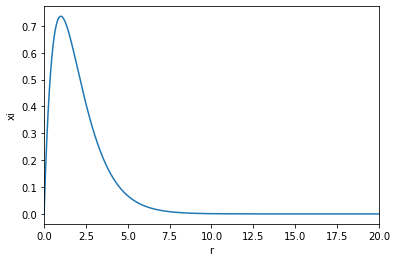

In [13]:
xi = r**(0.5) * y
plt.plot(r, xi)
plt.xlim(0, 20)
plt.xlabel('r')
plt.ylabel('xi')
plt.show()

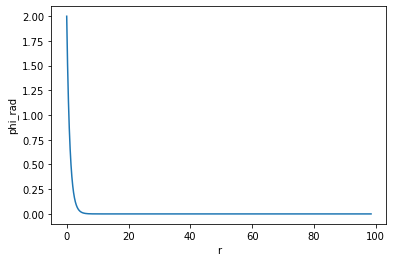

In [14]:
phi_rad = r**(-0.5) * y
plt.plot(r, phi_rad)
plt.xlabel('r')
plt.ylabel('phi_rad')
plt.show()

# Домашнее задание:

1) Исследовали решения как функцию n и l; проверили наличие случайного вырождения. 

In [15]:
n = 3
l = []
for i in range(0, n):
    l.append(i)
for i in range(len(l)):
    energy = solveRadialShrodingerEquation(n, l[i], uniformMesh, coulombPotential, 1)[0]
    print('n = ', n, 'l = ', l[i], 'energy = ', energy)
n = 5
l = []
for i in range(0, n):
    l.append(i)
for i in range(len(l)):
    energy = solveRadialShrodingerEquation(n, l[i], uniformMesh, coulombPotential, 1)[0]
    print('n = ', n, 'l = ', l[i], 'энергия = ', energy)

n =  3 l =  0 energy =  -0.11111111130919392
n =  3 l =  1 energy =  -0.11111111121830201
n =  3 l =  2 energy =  -0.11111111113722569
n =  5 l =  0 энергия =  -0.039999934533990984
n =  5 l =  1 энергия =  -0.03999995088281463
n =  5 l =  2 энергия =  -0.039999973355926505
n =  5 l =  3 энергия =  -0.03999999052744594
n =  5 l =  4 энергия =  -0.03999999832063219


По данным видно, что энергия обратно пропорциональна квадрату главного квантового числа. Имеется вырождение для энергетических уровней с одинаковыми значениями n и разными l (0, ..., (n-1))

2) Рассмотрели решение как функцию ядерного заряда Z.

Z =  1 энергия =  -1.0000000002334528 1.9993294170696834
Z =  2 энергия =  -4.000000000934777 5.654957554544724
Z =  3 энергия =  -9.000000002098034 10.388820394184958
Z =  4 энергия =  -16.00000000373225 15.994635336397675
Z =  5 энергия =  -25.000000005833407 22.353182429676718


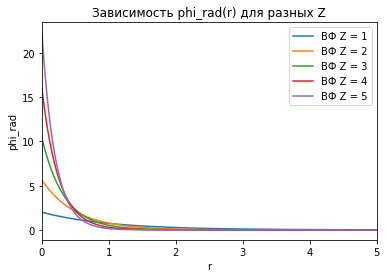

In [16]:
Z = [1, 2, 3, 4, 5] 
for i in range(len(Z)):
    r = uniformMeshToLogorithmicMesh(uniformMesh, Z[i])
    energy, y = solveRadialShrodingerEquation(1, 0, uniformMesh, coulombPotential, Z[i])
    #psi_norm = normalizeWF(r**(-0.5) * y , r, uniformMesh[1] - uniformMesh[0])
    phi_rad = r**(-0.5) * y
    plt.plot(r, phi_rad, label = 'ВФ Z = ' + str(Z[i]))
    print('Z = ', Z[i], 'энергия = ', energy, phi_rad[0])
plt.legend()
plt.title('Зависимость phi_rad(r) для разных Z')
plt.xlim(0, 5)
plt.xlabel('r')
plt.ylabel('phi_rad')
plt.show()

По данным видно, что энергия прямо пропорциональна квадрату зарядового числа. Зависимость радиальной ВФ от зарядового числа представлена на графике. ВФ имеет вид убывающей экспоненты в зависимости от расстояния. При r->0 ВФ прямо пропорциональна $Z$. 

3) Слегка изменили потенциал: $V(r) = \frac{-Z*q^2}{r^{1+\delta}}$

In [17]:
r = uniformMeshToLogorithmicMesh(uniformMesh, 1)

def changed_coulombPotential001(r, zeta):
    """
    Note factor 2.0 due to atomic units with Ry
    """
    delta = 0.01
    return -2.0 * zeta / r**(1+delta)

def changed_coulombPotential01(r, zeta):
    """
    Note factor 2.0 due to atomic units with Ry
    """
    delta = 0.1
    return -2.0 * zeta / r**(1+delta)

4) Посчитали математическое ожидание r и 1/r.

$E(R) = \int \psi^* * r *\psi* 4\pi r^2 dr$,
$E(1/R) = \int \psi^* * \frac{1}{r} *\psi* 4\pi r^2 dr$


In [18]:
phi_rad_col = normalizeWF(r**(-0.5) * solveRadialShrodingerEquation(1, 0, uniformMesh, coulombPotential, 1)[1], r, uniformMesh[1] - uniformMesh[0])
phi_rad_cha001 = normalizeWF(r**(-0.5) * solveRadialShrodingerEquation(1, 0, uniformMesh, changed_coulombPotential001, 1)[1], r, uniformMesh[1] - uniformMesh[0])
phi_rad_cha01 = normalizeWF(r**(-0.5) * solveRadialShrodingerEquation(1, 0, uniformMesh, changed_coulombPotential01, 1)[1], r, uniformMesh[1] - uniformMesh[0])

deltaX = uniformMesh[1]-uniformMesh[0]
ER = 0
EE = 0
for i in range(1, len(r)):
    ER += (phi_rad_col[i] ** 2) * (r[i] ** 3) * deltaX
    EE += (phi_rad_col[i] ** 2) * r[i] * deltaX * (-1)
print('Известные аналитические результаты для кулоновского потенциала, в Ry системе единиц')
print('Z = ', 1,  'n = ', 1, 'l = ', 0, 'средний r = ', round(ER ,2 ), 'средняя E = ', round(EE, 2), 'Ry')

ER = 0
EE = 0
for i in range(1, len(r)):
    ER += (phi_rad_cha001[i] ** 2) * (r[i] ** 3) * deltaX
    EE += (phi_rad_cha001[i] ** 2) * r[i] * deltaX * (-1)
print('Известные аналитические результаты для кулоновского потенциала, в Ry системе единиц')
print('Z = ', 1,  'n = ', 1, 'l = ', 0, 'delta = ', 0.01, 'средний r = ', round(ER ,2 ), 'средняя E = ', round(EE, 2), 'Ry')

ER = 0
EE = 0
for i in range(1, len(r)):
    ER += (phi_rad_cha01[i] ** 2) * (r[i] ** 3) * deltaX
    EE += (phi_rad_cha01[i] ** 2) * r[i] * deltaX * (-1)
print('Известные аналитические результаты для кулоновского потенциала, в Ry системе единиц')
print('Z = ', 1,  'n = ', 1, 'l = ', 0, 'delta = ', 0.1, 'средний r = ', round(ER ,2 ), 'средняя E = ', round(EE, 2), 'Ry')

Известные аналитические результаты для кулоновского потенциала, в Ry системе единиц
Z =  1 n =  1 l =  0 средний r =  1.0 средняя E =  -2.0 Ry
Известные аналитические результаты для кулоновского потенциала, в Ry системе единиц
Z =  1 n =  1 l =  0 delta =  0.01 средний r =  0.99 средняя E =  -2.03 Ry
Известные аналитические результаты для кулоновского потенциала, в Ry системе единиц
Z =  1 n =  1 l =  0 delta =  0.1 средний r =  0.87 средняя E =  -2.37 Ry


Видно, что чем больше delta, тем сильнее отличаются значения средней энергии и боровского радиуса. 

5) Рассмотрели другое отображение: $r(x) = r_0(exp(x)−1), \frac{\Delta r}{\Delta x} = r + r_0, r_0 = \frac{1}{Z}$.
Добавили новую функцию new_uniformMeshToLogorithmicMesh. 

В данном случае $y(x) = \frac{\chi}{\sqrt{r+r_0}}$. В идеале необходимо в функции new_solveRadialShrodingerEquation менять $g = (E-V)(r+r_0)^2 - l(l+1)(1+ \frac{r_0}{r})^2 - 1/4$, так как $\frac{\Delta r}{\Delta x} \neq r $. 

Энергия = -1.0153712350807842


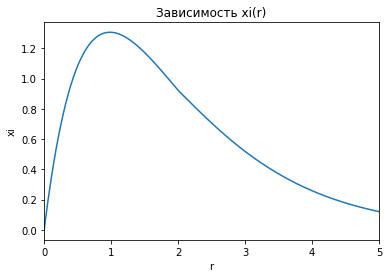

In [20]:
def new_uniformMeshToLogorithmicMesh(uniformMesh, zeta, verbose=False):
    """
    """
    deltaX = uniformMesh[1] - uniformMesh[0]
    logorithmicMesh = (np.exp(uniformMesh) - 1)/ zeta
    if verbose:
        print("Radial grid information:")
        print("deltaX   = {0:10.6f}, xMin = {1:10.6f}, zeta = {2:10d}".format(deltaX, min(uniformMesh), zeta))
        print("meshSize = {0:10d}, r(0) = {1:10.6f}, r(meshSize) = {2:10.6f}".format(len(uniformMesh), 
                                                                                     logorithmicMesh[0],
                                                                                     logorithmicMesh[-1]))
    return logorithmicMesh
 
def new_solveRadialShrodingerEquation(n, l, uniformMesh, potential, zeta,
                                  maximumNumberOfInterations = 100,
                                  tolerance = 1E-10,
                                  verbose=False):
    """
    Solve the schroedinger equation in radial coordinates on a 
    logarithmic grid by Numerov method - atomic (Ry) units
    """
    deltaX = uniformMesh[1] - uniformMesh[0]
    meshSize = len(uniformMesh)
    r = new_uniformMeshToLogorithmicMesh(uniformMesh, zeta)
    centrifugalPotential = (l + 0.5)**2 / r**2
    numberOfNodes = n - l - 1
    
    # Set (very rough) initial lower and upper bounds to the eigenvalue
    maxEnergy  = potential(r, zeta)[-1]
    minEnergy = min(potential(r, zeta) + centrifugalPotential)

    energy = 0.5 * (minEnergy + maxEnergy)

    # Print header
    if verbose:
        print("(Number Of Iterations)(Energy)(Minimum energy)(Maximum Energy)" 
              + "(Delta energy)(Current number of nodes)(Target number of nodes)")
    
    y = np.zeros(meshSize)
    numberOfIterations = 0
    while numberOfIterations < maximumNumberOfInterations:
        numberOfIterations += 1
        # Set up the g-function 
        # Determine the position of g last change of sign
        # g < 0 (approximately) means classically allowed   region
        # g > 0         "         "        "      forbidden   "
        g = (((r+1/zeta)**2) * (energy - potential(r, zeta)) - l*(l+1)*(1+1/(zeta*r))**2 -1/4) 
        f = 1 + g * deltaX**2 / 12.0
        turningPointIndex = getTurningPointIndex(uniformMesh, g)
        
        if turningPointIndex == -1 or turningPointIndex == (meshSize - 1):
            maxEnergy = energy
            energy = (minEnergy + maxEnergy) / 2.0
            continue
        
        numberOfNodes = n - l - 1
        errorMessage = "Number of nodes should be greater or equal to zero."
        errorMessage += "Please, chose right n, l quantum numbers!"
        assert numberOfNodes >= 0, errorMessage 
        # Determination of the wave-function in the first two points
        # (assymtotic behavior - second term depends upon potential)
        y0 = r[0]**(l+0.5) * (1.0 - 2.0 * zeta * r[0] / (2 * l + 2))
        y1 = r[1]**(l+0.5) * (1.0 - 2.0 * zeta * r[1] / (2 * l + 2))
        # Outward integration, count number of crossings
        y[:(turningPointIndex+1)] = numerovIntegrationScheme(g[:(turningPointIndex+1)], y0, y1, deltaX)
        yLeft = y[turningPointIndex]
        yNodes = howManyNodes(y[:turningPointIndex]) 
        if  yNodes != numberOfNodes:
            if yNodes > numberOfNodes:
                maxEnergy = energy
                energy = (minEnergy + maxEnergy) / 2.0
            else:
                minEnergy = energy
                energy = (minEnergy + maxEnergy) / 2.0
            if verbose:
                formatString = "{0:10d}\t{1:10.10f}\t{2:10.10f}\t{3:10.10f}\t{4:10s}\t{5:10d}\t{6:10d}" 
                print(formatString.format(numberOfIterations, energy, minEnergy, maxEnergy, "---",
                                          yNodes, numberOfNodes))
            continue           
        # Determination of the wave-function in the last two points
        # Assuming y[mesh+1] = 0 and y[mesh] = dx
        y0 = deltaX 
        y1 = (12.0 - 10.0 * f[-1]) * y0 / f[-1]
        # Inward integration
        y[turningPointIndex:] = numerovIntegrationSchemeReverse(g[turningPointIndex:], y0, y1, deltaX)
        yRight = y[turningPointIndex]
        # Scaling wave function 
        y[turningPointIndex:] *= yLeft / yRight
        # Normalizing  wave fucntion
        y = normalizeWF(y, r, deltaX)
        # Find the value of the cusp at the matching point (turning point)
        i = turningPointIndex
        yCusp = (y[i-1] * f[i-1] + f[i+1] * y[i+1] + 10.0 * f[i] * y[i]) / 12.0
        deltaFCusp = f[i] * (y[i] / yCusp - 1.0)
        # Eigenvalue update using perturbation theory
        deltaEnergy = deltaFCusp * 12.0 / deltaX**2 * yCusp * yCusp * deltaX
        if (deltaEnergy > 0.0):
            minEnergy = energy
        else:
            maxEnergy = energy
        # Prevent energy to go out of bounds, i.e. energy > maxEnergy or energy < minEnergy
        # (might happen far from convergence)
        energy = max(min(energy + deltaEnergy, maxEnergy), minEnergy)
        if verbose:
                formatString = "{0:10d}\t{1:10.10f}\t{2:10.10f}\t{3:10.10f}\t{4:10.10f}\t{5:10d}\t{6:10d}" 
                print(formatString.format(numberOfIterations, energy, minEnergy, maxEnergy, deltaEnergy,
                                          yNodes, numberOfNodes))
        # Convergence check     
        if abs(deltaEnergy) < tolerance:
            break
    return energy, y

zeta = 1
new_uniformMesh = np.linspace(0.0000001, 4.59, 1260)
r = new_uniformMeshToLogorithmicMesh(new_uniformMesh, zeta)
energy, y = new_solveRadialShrodingerEquation(1, 0, new_uniformMesh, coulombPotential, zeta)
print('Энергия =', energy)
xi = (r+1/zeta)**(0.5) * y
plt.plot(r, xi)
plt.title('Зависимость xi(r)')
plt.xlim(0, 5)
plt.xlabel('r')
plt.ylabel('xi')
plt.show()

# Дополнительное задание:

1) Поменяем граничные условия, отбросим член $((1.0 - zeta * r_0 / (l + 1))$. Так как при r->0 $\chi \sim r^{l+1}, y \sim r^{l+0.5}$. Можно написать, что $y_0 = r_0*(l+0.5), y_1 = r_1*(l+0.5)$

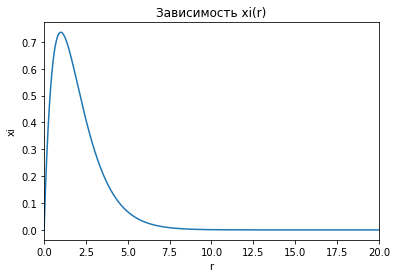

In [23]:
def nzc_solveRadialShrodingerEquation(n, l, uniformMesh, potential, zeta,
                                  maximumNumberOfInterations = 100,
                                  tolerance = 1E-10,
                                  verbose=False):
    """
    Solve the schroedinger equation in radial coordinates on a 
    logarithmic grid by Numerov method - atomic (Ry) units
    """
    deltaX = uniformMesh[1] - uniformMesh[0]
    meshSize = len(uniformMesh)
    r = uniformMeshToLogorithmicMesh(uniformMesh, zeta)
    centrifugalPotential = (l + 0.5)**2 / r**2
    numberOfNodes = n - l - 1
    
    # Set (very rough) initial lower and upper bounds to the eigenvalue
    maxEnergy  = potential(r, zeta)[-1]
    minEnergy = min(potential(r, zeta) + centrifugalPotential)

    energy = 0.5 * (minEnergy + maxEnergy)

    # Print header
    if verbose:
        print("(Number Of Iterations)(Energy)(Minimum energy)(Maximum Energy)" 
              + "(Delta energy)(Current number of nodes)(Target number of nodes)")
    
    y = np.zeros(meshSize)
    numberOfIterations = 0
    while numberOfIterations < maximumNumberOfInterations:
        numberOfIterations += 1
        # Set up the g-function 
        # Determine the position of g last change of sign
        # g < 0 (approximately) means classically allowed   region
        # g > 0         "         "        "      forbidden   "
        g = (r**2 * (energy - potential(r, zeta)) - (l + 0.5)**2) 
        f = 1 + g * deltaX**2 / 12.0
        turningPointIndex = getTurningPointIndex(uniformMesh, g)
        
        if turningPointIndex == -1 or turningPointIndex == (meshSize - 1):
            maxEnergy = energy
            energy = (minEnergy + maxEnergy) / 2.0
            continue
        
        numberOfNodes = n - l - 1
        errorMessage = "Number of nodes should be greater or equal to zero."
        errorMessage += "Please, chose right n, l quantum numbers!"
        assert numberOfNodes >= 0, errorMessage 
        # Determination of the wave-function in the first two points
        # (assymtotic behavior - second term depends upon potential)
        y0 = r[0]**(l+0.5) 
        y1 = r[1]**(l+0.5)
        # Outward integration, count number of crossings
        y[:(turningPointIndex+1)] = numerovIntegrationScheme(g[:(turningPointIndex+1)], y0, y1, deltaX)
        yLeft = y[turningPointIndex]
        yNodes = howManyNodes(y[:turningPointIndex]) 
        if  yNodes != numberOfNodes:
            if yNodes > numberOfNodes:
                maxEnergy = energy
                energy = (minEnergy + maxEnergy) / 2.0
            else:
                minEnergy = energy
                energy = (minEnergy + maxEnergy) / 2.0
            if verbose:
                formatString = "{0:10d}\t{1:10.10f}\t{2:10.10f}\t{3:10.10f}\t{4:10s}\t{5:10d}\t{6:10d}" 
                print(formatString.format(numberOfIterations, energy, minEnergy, maxEnergy, "---",
                                          yNodes, numberOfNodes))
            continue           
        # Determination of the wave-function in the last two points
        # Assuming y[mesh+1] = 0 and y[mesh] = dx
        y0 = deltaX 
        y1 = (12.0 - 10.0 * f[-1]) * y0 / f[-1]
        # Inward integration
        y[turningPointIndex:] = numerovIntegrationSchemeReverse(g[turningPointIndex:], y0, y1, deltaX)
        yRight = y[turningPointIndex]
        # Scaling wave function 
        y[turningPointIndex:] *= yLeft / yRight
        # Normalizing  wave fucntion
        y = normalizeWF(y, r, deltaX)
        # Find the value of the cusp at the matching point (turning point)
        i = turningPointIndex
        yCusp = (y[i-1] * f[i-1] + f[i+1] * y[i+1] + 10.0 * f[i] * y[i]) / 12.0
        deltaFCusp = f[i] * (y[i] / yCusp - 1.0)
        # Eigenvalue update using perturbation theory
        deltaEnergy = deltaFCusp * 12.0 / deltaX**2 * yCusp * yCusp * deltaX
        if (deltaEnergy > 0.0):
            minEnergy = energy
        else:
            maxEnergy = energy
        # Prevent energy to go out of bounds, i.e. energy > maxEnergy or energy < minEnergy
        # (might happen far from convergence)
        energy = max(min(energy + deltaEnergy, maxEnergy), minEnergy)
        if verbose:
                formatString = "{0:10d}\t{1:10.10f}\t{2:10.10f}\t{3:10.10f}\t{4:10.10f}\t{5:10d}\t{6:10d}" 
                print(formatString.format(numberOfIterations, energy, minEnergy, maxEnergy, deltaEnergy,
                                          yNodes, numberOfNodes))
        # Convergence check     
        if abs(deltaEnergy) < tolerance:
            break
    
    
    return energy, y

zeta = 1
r = uniformMeshToLogorithmicMesh(uniformMesh, zeta)
uniformMesh = np.linspace(-8, 4.59, 1260)
energy, y = nzc_solveRadialShrodingerEquation(1, 0, uniformMesh, coulombPotential, 1)
xi = r**(0.5) * y
plt.plot(r, xi)
plt.title('Зависимость xi(r)')
plt.xlim(0, 20)
plt.xlabel('r')
plt.ylabel('xi')
plt.show()



Видно, что изменение начальных условий не отразились на качестве результатов. 

2) Сравнили сходимость, когда использовали ТВ и разрыв в первой производной. 

In [24]:
def getFirstDerivativeDiscontinuity(y, g, deltaX, turningPointIndex):
    """
    """
    f = 1 + g * (deltaX)**2 / 12.0
    firstDerivativeDiscontinuity = (y[turningPointIndex - 1] + y[turningPointIndex + 1] 
                                    - (14.0 - 12.0 * f[turningPointIndex]) * y[turningPointIndex]) / deltaX 
    return firstDerivativeDiscontinuity

def firstdergap_solveRadialShrodingerEquation(n, l, uniformMesh, potential, zeta,
                                  maximumNumberOfInterations = 100,
                                  tolerance = 1E-6,
                                  verbose=False, convergence=False):
    """
    Solve the schroedinger equation in radial coordinates on a 
    logarithmic grid by Numerov method - atomic (Ry) units
    """
    deltaX = uniformMesh[1] - uniformMesh[0]
    meshSize = len(uniformMesh)
    r = uniformMeshToLogorithmicMesh(uniformMesh, zeta)
    centrifugalPotential = (l + 0.5)**2 / r**2
    numberOfNodes = n - l - 1
    Energy = []
    Iterations = []
    
    # Set (very rough) initial lower and upper bounds to the eigenvalue
    maxEnergy  = potential(r, zeta)[-1]
    minEnergy = min(potential(r, zeta) + centrifugalPotential)

    energy = (minEnergy + maxEnergy)/2.0

    # Print header
    if verbose:
        print("(Number Of Iterations)(Energy)(Minimum energy)(Maximum Energy)" 
              + "(Delta energy)(Current number of nodes)(Target number of nodes)")
    
    y = np.zeros(meshSize)
    numberOfIterations = 0
    Iterations.append(numberOfIterations)
    Energy.append(energy)
    while numberOfIterations < maximumNumberOfInterations:
        numberOfIterations += 1
        # Set up the g-function 
        # Determine the position of g last change of sign
        # g < 0 (approximately) means classically allowed   region
        # g > 0         "         "        "      forbidden   "
        g = (r**2 * (energy - potential(r, zeta)) - (l + 0.5)**2) 
        f = 1 + g * deltaX**2 / 12.0
        turningPointIndex = getTurningPointIndex(uniformMesh, g)
        
        #if turningPointIndex == -1 or turningPointIndex == (meshSize - 1):
        #    maxEnergy = energy
        #    energy = (minEnergy + maxEnergy) / 2.0
        #    continue
        
        numberOfNodes = n - l - 1
        errorMessage = "Number of nodes should be greater or equal to zero."
        errorMessage += "Please, chose right n, l quantum numbers!"
        assert numberOfNodes >= 0, errorMessage 
        # Determination of the wave-function in the first two points
        # (assymtotic behavior - second term depends upon potential)
        y0 = r[0]**(l+0.5) * (1.0 - 2.0 * zeta * r[0] / (2 * l + 2))
        y1 = r[1]**(l+0.5) * (1.0 - 2.0 * zeta * r[1] / (2 * l + 2))
        # Outward integration, count number of crossings
        y[:(turningPointIndex+1)] = numerovIntegrationScheme(g[:(turningPointIndex+1)], y0, y1, deltaX)
        yLeft = y[turningPointIndex]
        yNodes = howManyNodes(y[:turningPointIndex]) 
        if  yNodes != numberOfNodes:
            Iterations.append(numberOfIterations)
            if yNodes > numberOfNodes:
                maxEnergy = energy
                energy = (minEnergy + maxEnergy) / 2.0
                Energy.append(energy)
            else:
                minEnergy = energy
                energy = (minEnergy + maxEnergy) / 2.0
                Energy.append(energy)
            if verbose:
                print('Hello', maxEnergy, minEnergy)
                formatString = "{0:10d}\t{1:10.10f}\t{2:10.10f}\t{3:10.10f}\t{4:10s}\t{5:10d}\t{6:10d}" 
                print(formatString.format(numberOfIterations, energy, minEnergy, maxEnergy, "---",
                                          yNodes, numberOfNodes))
            continue           
        # Determination of the wave-function in the last two points
        # Assuming y[mesh+1] = 0 and y[mesh] = dx
        y0 = deltaX 
        y1 = (12.0 - 10.0 * f[-1]) * y0 / f[-1]
        # Inward integration
        y[turningPointIndex:] = numerovIntegrationSchemeReverse(g[turningPointIndex:], y0, y1, deltaX)
        yRight = y[turningPointIndex]
        # Scaling wave function 
        y[turningPointIndex:] *= yLeft / yRight
        # Normalizing  wave fucntion
        y = normalizeWF(y, r, deltaX)
        # Find the value of the cusp at the matching point (turning point)
        
        firstDerivativeDiscontinuity = getFirstDerivativeDiscontinuity(y, g, deltaX, turningPointIndex)                        
        
        if (firstDerivativeDiscontinuity * y[turningPointIndex] <= 0):
                minEnergy = energy
        else: 
                maxEnergy = energy  
                
        energy = (minEnergy + maxEnergy) / 2.0
        
        if verbose:
                formatString = "{0:10d}\t{1:10.10f}\t{2:10.10f}\t{3:10.10f}\t{4:10.10f}\t{5:10d}\t{6:10d}" 
                print(formatString.format(numberOfIterations, energy, minEnergy, maxEnergy, abs(maxEnergy - minEnergy),
                    yNodes, numberOfNodes))
                
        Iterations.append(numberOfIterations)
        Energy.append(energy)
        # Convergence check     
        if abs(maxEnergy - minEnergy) < tolerance:
            break
    if convergence == True:
        return energy, y, Iterations, Energy
    else:
        return energy, y
   

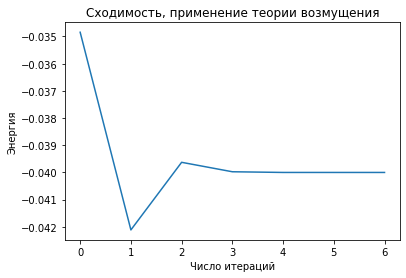

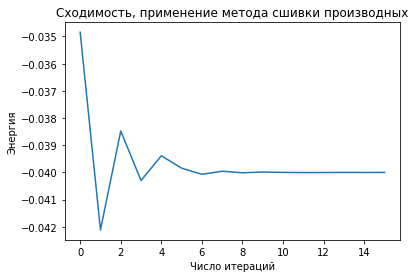

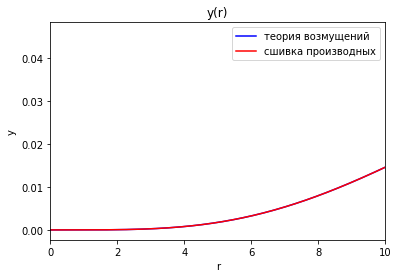

In [26]:
zeta = 1
r = uniformMeshToLogorithmicMesh(uniformMesh, 1)
uniformMesh = np.linspace(-8, 4.59, 1260)
n =5
l = 4

energy, TV_y, TV_Iterations, TV_Energy = solveRadialShrodingerEquation(n, l, uniformMesh, coulombPotential, 1, convergence=True)
plt.plot(TV_Iterations, TV_Energy)
plt.title('Сходимость, применение теории возмущения')
plt.xlabel('Число итераций')
plt.ylabel('Энергия')
plt.show()

energy, FGD_y, FGD_Iterations, FGD_Energy = firstdergap_solveRadialShrodingerEquation(n, l, uniformMesh, coulombPotential, 1, convergence=True)
plt.plot(FGD_Iterations, FGD_Energy)
plt.title('Сходимость, применение метода сшивки производных')
plt.xlabel('Число итераций')
plt.ylabel('Энергия')
plt.show()


plt.plot(r, TV_y, 'b', label = 'теория возмущений')
plt.plot(r, FGD_y, 'r', label = 'сшивка производных')
plt.title('y(r)')
plt.legend()
plt.xlabel('r')
plt.ylabel('y')
plt.xlim(0,10)
plt.show()

Видно, что ВФ в обоих случаях одинаковая. Метод ТВ обеспечивает более быструю сходимость. Энергия почти не меняется уже на 4-5 шаге. Что касается второго метода, основанного на сшивки первой производной, по сходимости он отстает от первого метода на 2-3 шага (в зависимости от n). Следовательно, он тожк применим. 